You can convert this notebook to slides using

```bash
jupyter nbconvert --to slides nnjax.ipynb
```

# Neural Networks and Backpropagation

**What's the plan for today's tutorial?**

We could

* compute forward and backpropagation manually 🙅
* learn how to use a library 🙄
* implement a neural network from scratch (you will do that in the exercise) 😉
* **learn how a neural network library works** 🙆
    * What does a modern neural network library need?
    * What are the theoretical concepts behind it?
    * What's the technical background?
    * Example: JAX

## But Let's Start with Some Questions...

> **Before we start!** Install JAX: https://jax.readthedocs.io/en/latest/installation.html
>
> (You won't need GPU support.)

* What does a single neuron of an artificial neural network do?
* How is that similar to linear and logistic regression?
* What is an activation function?
* What is an error function (aka loss)?
* What is forward propagation?
* What is backpropagation?
* What is a gradient?
* What is gradient descent?
* What is stochastic gradient descent?

# JAX: How does it work?

JAX is
* **NumPy** on the **CPU, GPU, and TPU**,
* with great **automatic differentiation**
* for high-performance machine learning **research**.

In [1]:
import jax.numpy as jnp

## Example: Parameter Initialization

We want to create a fully connected feedforward neural network with the following structure:

* Input layer with 1 input
* 2 hidden layers with 50 and 30 neurons
* Output layer with 1 output

In [2]:
# Number of neurons per layer of a fully connected neural network
layer_sizes = [1, 50, 30, 1]

Random number generation in JAX is a bit complicated. We skip this part. If you want to learn more about it later, click [here](https://jax.readthedocs.io/en/latest/jax.random.html).

In [3]:
from jax import random


def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


def random_layer_params(m, n, key, scale=1e-1):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

In [4]:
params = init_network_params(layer_sizes, random.PRNGKey(0))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Neural Network Operations and GPU Code

## Forward Propagation per Neuron

In each layer
$$a_j = b_j + \sum_i w_{ji} x_i$$
$$y_j = g(a_j)$$

where
* $y_j$ is the $j$th output
* $x_i$ is the $i$th input
* $w_{ji}$ is a weight
* $b_j$ is the bias
* $a_{j}$ is called activation
* $g$ is the activation function, e.g., $\tanh$ in the hidden layers and the identity in the last layer (for regression)

## Simplification for Fully Connected Neural Network

$$\boldsymbol{a} = \boldsymbol{W} \boldsymbol{x} + \boldsymbol{b}$$

where
* $\boldsymbol{a} = (\ldots, a_j, \ldots)^T$
* $\boldsymbol{W} = \left( \begin{array}{ccc}\ddots & \vdots & \vdots\\ \vdots & w_{ji} & \vdots\\ \vdots & \vdots & \ddots\end{array}\right)$
* $\boldsymbol{x} = (\ldots, x_i, \ldots)^T$
* $\boldsymbol{b} = (\ldots, b_j, \ldots)^T$

## Required Operations for Forward propagation
* Weighted sum of multiple neurons, can be expressed as matrix-vector product: $\boldsymbol{W} \cdot \boldsymbol{x}$
* Element-wise sum
* Apply activation function to all elements of an array

**Task:** Implement forward propagation of a fully connected neural network.

In [5]:
def predict(params, x):
    """Forward proapagation of fully connected neural network.

    In each hidden layer, we compute the activation through matrix-vector
    multiplication of W and x, add the bias vector and apply the activation
    function tanh.

    Parameters
    ----------
    params : list of tuples of jax Array
        Each entry of the list is a tuple (pair) of a weight matrix W and a
        bias vector b. The length of this list corresponds to the number of
        hidden layers and the output layer.

    x : jax Array
        Input vector.

    Returns
    -------
    y : jax Array
        Output of the neural network.
    """
    raise NotImplementedError()

In [6]:
x = random.normal(random.PRNGKey(1), (1,))
predict(params, x)

Array([-0.00251399], dtype=float32)

## JAX vmap

We usually want to predict batches of samples in parallel. This can be done via vectorization. JAX' vmap can do this automatically for you.

*Note that JAX also has another similar function called `pmap`, which parallelizes the function.*

In [7]:
%%html
<iframe src="https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html" width="600" height="400"></iframe>

In [8]:
from jax import vmap


batched_predict = vmap(predict, in_axes=(None, 0))

In [9]:
X = random.normal(random.PRNGKey(1), (10, 1))
batched_predict(params, X)

Array([[-0.00715889],
       [-0.00354905],
       [-0.00254714],
       [-0.00505155],
       [-0.00418208],
       [-0.00350995],
       [-0.00819672],
       [-0.01279369],
       [-0.0037919 ],
       [-0.00511977]], dtype=float32)

## Error Function: Mean Squared Error
$$E = \frac{1}{2 N} \sum_n \sum_j \left( y_j^{(n)} - t_j^{(n)} \right)^2$$
or more compactly:
$$E = \frac{1}{2 N} ||\boldsymbol{Y} - \boldsymbol{T}||_2^2$$
where
* $||.||_2$ is the [Frobenius norm](http://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm), extension of the Euclidean norm to matrices.

## Required Operations for Loss Computation

* Element-wise subtraction of matrices
* Element-wise square of a matrix
* Mean of a matrix

**Task:** Implement mean squared error.

In [10]:
def loss(params, X, y):
    """Mean squared error.

    Parameters
    ----------
    params : list of tuples of jax Array
        Each entry of the list is a tuple (pair) of a weight matrix W and a
        bias vector b. The length of this list corresponds to the number of
        hidden layers and the output layer.

    X : jax Array, shape (n_samples, n_features)
        Input vector.

    y : jax Array, shape (n_samples,)
        Target values.

    Returns
    -------
    loss : jax Array, scalar
        Mean squared error.
    """
    y_pred = batched_predict(params, X)
    raise NotImplementedError()

## Optimized Backpropagation for Fully Connected Layers
In each layer
$$\text{Step 1: }\Delta = g'(\boldsymbol{A}) * \frac{\partial E}{\partial \boldsymbol{Y}} \text{; Step 2: }\frac{\partial E}{\partial \boldsymbol{W}} = \Delta^T \cdot \boldsymbol{X} \text{; Step 3: }\frac{\partial E}{\partial \boldsymbol{X}} = \Delta \cdot \boldsymbol{W}$$
where
* $*$ is the [Hadamard product](http://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29) or Schur product or entrywise product
* $\frac{\partial E}{\partial \boldsymbol{Y}}$ contains derivatives of the error function with respect to the outputs ($\boldsymbol{Y} - \boldsymbol{T} = \frac{\partial E}{\partial \boldsymbol{Y}}$ in the last layer)
* $\frac{\partial E}{\partial \boldsymbol{X}} \in \mathbb{R}^{N \times I}$ contains derivatives of the error function with respect to the inputs and will be passed to the previous layer
* $\Delta \in \mathbb{R}^{N \times J}$ contains deltas: $\delta_j^{(n)} = \Delta_{jn}$
* $g'$ is the derivative of $g$
* $\frac{\partial E}{\partial \boldsymbol{W}} \in \mathbb{R}^{J \times I}$ contains the derivatives of the error function with respect to $\boldsymbol{W}$ and will be used to update the weights

## Required Operations for Backprop

* Element-wise matrix product
* Matrix product
* Matrix transpose
* Element-wise application of derivate of activation function

**Good news:** You don't have to implement that!

# Automatic Differentiation

> What AD is not:
>
> * AD is not numerical differentiation
> * AD is not symbolic differentiation

Baydin, Pearlmutter, Radul, Siskind (2018): Automatic Differentiation in Machine Learning: a Survey, https://www.jmlr.org/papers/volume18/17-468/17-468.pdf

> \[..\] JAX can automatically differentiate native Python and NumPy code. It can differentiate through a large subset of Python’s features, including loops, ifs, recursion, and closures, and it can even take derivatives of derivatives of derivatives. It supports **reverse-mode** as well as **forward-mode** differentiation, and the two can be composed arbitrarily to any order.

[JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)

In [11]:
%%html
<iframe src="https://jax.readthedocs.io/en/latest/jax.html#automatic-differentiation" width="600" height="400"></iframe>

Scalar functions

$$f_1: \mathbb{R} \rightarrow \mathbb{R}$$
$$f_1(x) = x^2$$
$$f_1'(x) = 2 x$$

In [12]:
from jax import grad


def f1(x):
    return x ** 2

**Task:** Compute the gradient of `f1` at $x=1$.

In [13]:
raise NotImplementedError()

Array(2., dtype=float32, weak_type=True)

Vector-valued functions and Jacobians

$$f_2: \mathbb{R}^3 \rightarrow \mathbb{R}^4$$

$$
f_2(\boldsymbol{x}) =
\left(
\begin{array}{c}
x_1^2\\
5 x_3\\
4 x_2^3\\
x_3 \sin{x_1}
\end{array}
\right)
$$

$$f_2'(x) \in \mathbb{R}^{4 \times 3} \textrm{ (Jacobian matrix)}$$

In [14]:
from jax import jacfwd


def f2(x):
    return jnp.asarray([x[0] ** 2, 5*x[2], 4*x[1]**3 - 2*x[2], x[2] * jnp.sin(x[0])])

**Task:** Compute the gradient of `f2` at $x=(1, 2, 3)$.

In [15]:
raise NotImplementedError()

Array([[ 2.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  5.        ],
       [ 0.        , 48.        , -2.        ],
       [ 1.6209068 ,  0.        ,  0.84147096]], dtype=float32)

2nd derivative of multivariate functions: Hessian matrix

$$f_3: \mathbb{R}^3 \rightarrow \mathbb{R}$$
$$f_3(\boldsymbol{x}) = \boldsymbol{x}^T\boldsymbol{x}$$
$$f_3''(\boldsymbol{x}) \in \mathbb{R}^{3 \times 3}$$

In [16]:
from jax import hessian


def f3(x):
    return jnp.dot(x, x)

**Task:** Compute the gradient and Hessian of `f3` at $x=(3, 2, 1)$.

In [17]:
raise NotImplementedError()

Array([6., 4., 2.], dtype=float32)

In [18]:
raise NotImplementedError()

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

## Forward Mode
* Generalizes naturally to computing the Jacobian of a function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$ ($n$ forward passes of the function required).
* Hence, it is better for multivariate functions with many outputs.
* Mathematically, forward mode AD can be viewed as evaluating a function using **dual numbers**.

### Dual Numbers
$$v + \dot{v} \epsilon,$$
where
* $v, \dot{v} \in \mathbb{R}$, stored as a pair in memory (Argand pair, similar to complex number)
* $\epsilon \neq 0, \epsilon^2 = 0$ (nilpotent number)
Observe that
$$(v + \dot{v}\epsilon) + (u + \dot{u}\epsilon) = (v+u) + (\dot{v}+\dot{u})\epsilon$$
$$(v + \dot{v}\epsilon) (u + \dot{u}\epsilon) = (vu) + (\dot{v}\dot{u})\epsilon,$$
in which the coefficient of $\epsilon$ conveniently mirror symbolic differentiation rules.

We can utilize this by setting up a regime where
$$f(v+\dot{v}\epsilon) = f(v) + f'(v)\dot{v}\epsilon$$
and using dual numbers as data structures for carrying the tangent value together with the primal. The chain rule works as expected on this representation.

> **Example**
> $$f(x) = x^2 + 2x + 3$$
> What is $f'(x)$?
> $$f'(x) = 2x + 2$$
> For example, $f'(3) = 8$, $f'(-2) = -2$
> 
> Differentiation with dual numbers:
> $$f(3 + \epsilon) = (3 + \epsilon)^2 + 2 (3 + \epsilon) + 3$$
> $$= 9 + 6 \epsilon + 6 + 2 \epsilon + 3$$
> $$= 18 + \underline{8 \epsilon}$$
> $$f(-2 + \epsilon) = (-2 + \epsilon)^2 + 2 (-2 + \epsilon) + 3$$
> $$= 4 - 4 \epsilon - 4 + 2 \epsilon + 3$$
> $$= 3 \underline{- 2 \epsilon}$$

## Reverse Mode
* Corresponds to a **generalized backpropagation algorithm**, in that **it propagates derivatives backward**.
    * In the first phase, the original function is **run forward** recording the dependencies in the computational graph through a book-keeping procedure.
    * In the second phase, **derivatives are calculated by propagating from the outputs to the inputs**.
* It is significantly less costly to evaluate than the forward mode for functions with a **large number of inputs**.
* The advantages of the reverse mode come with the cost of **increased storage** requirements growing in the worst case in proportion to the number of operations in the evaluated function.

# JIT Decorator and XLA

```@jit``` - Sets up fun for just-in-time compilation with **XLA**.

In [19]:
%%html
<iframe src="https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html" width="600" height="400"></iframe>

## Accelerated Linear Algebra (XLA)

> \[..\] JAX uses [XLA](https://www.tensorflow.org/xla) to compile and run your NumPy code on accelerators, like **GPUs and TPUs**. Compilation happens under the hood by default \[..\]. But JAX even lets you just-in-time compile your own Python functions into **XLA-optimized kernels** \[..\].

[JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)

> XLA \[..\] is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.

https://www.tensorflow.org/xla

Objectives of XLA:
> * Improve execution speed.
> * Improve memory usage.
> * Reduce reliance on custom Ops.
> ...

https://www.tensorflow.org/xla/architecture

### Example

XLA \[..\] compiles the \[..\] graph into a sequence of computation kernels generated specifically for the given model. Because these kernels are unique to the model, they can exploit model-specific information for optimization. For example, let's look at an optimization XLA does in the context of a simple TensorFlow computation:

```python
def model_fn(x, y, z):
    return tf.reduce_sum(x + y * z)
```
Run without XLA, the graph launches three kernels:
* one for the multiplication,
* one for the addition and
* one for the reduction.

XLA can optimize the graph so that it computes the result in a single kernel launch. It does this by **"fusing" the addition, multiplication and reduction into a single GPU kernel**. This fused operation does not write out the intermediate values produced by `y*z` and `x+y*z` to memory; instead it "streams" the results of these intermediate computations directly to their users while keeping them entirely in GPU registers. Fusion is XLA's single most important optimization. **Memory bandwidth is typically the scarcest resource on hardware accelerators, so removing memory operations is one of the best ways to improve performance.**

## XLA in JAX

JAX analyzes the code of Python functions and converts it to HLO (high level operations). This only works when the input is known! Let's look at an example:

In [20]:
from jax import xla_computation


def model_fn(x, y, z):
    return jnp.sum(x + y * z)


x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([2.0, 2.0, 5.0])
z = jnp.array([3.0, -2.0, 15.0])
c = xla_computation(model_fn)(x, y, z)

In [21]:
print(c.as_hlo_text())

HloModule xla_computation_model_fn, entry_computation_layout={(f32[3]{0},f32[3]{0},f32[3]{0})->(f32[])}

region_0.7 {
  Arg_0.8 = f32[] parameter(0)
  Arg_1.9 = f32[] parameter(1)
  ROOT add.10 = f32[] add(Arg_0.8, Arg_1.9)
}

ENTRY main.13 {
  Arg_0.1 = f32[3]{0} parameter(0)
  Arg_1.2 = f32[3]{0} parameter(1)
  Arg_2.3 = f32[3]{0} parameter(2)
  multiply.5 = f32[3]{0} multiply(Arg_1.2, Arg_2.3)
  add.6 = f32[3]{0} add(Arg_0.1, multiply.5)
  constant.4 = f32[] constant(0)
  reduce.11 = f32[] reduce(add.6, constant.4), dimensions={0}, to_apply=region_0.7
  ROOT tuple.12 = (f32[]) tuple(reduce.11)
}




HLO can be converted to optimized low-level code for specific machines (CPU, GPU, ...).

In [22]:
# we can also export it to a dot graph:
#print(c.as_hlo_dot_graph())
# requires graphviz
#dot -Tpng hlo_graph.dot  > hlo_graph.png

<img src="hlo_graph.png" width="400px" />

### Example: Graph of Our Neural Network

In [23]:
#x = random.normal(random.PRNGKey(1), (1,))
#c = xla_computation(predict)(params, x)
#print(c.as_hlo_dot_graph())

<img src="hlo_graph2.png" width="60%"/>

## Example: Weight Update

**Task:**
1. Compute the gradient of the loss function with respect to the parameters of the neural network. Store them in the variable `grads`.
2. Accelerate the update function with XLA.

In [24]:
from jax import jit


def update(params, X, y, step_size):
    """Update weights of a neural network.

    Parameters
    ----------
    params : list of tuples of jax Array
        Each entry of the list is a tuple (pair) of a weight matrix W and a
        bias vector b. The length of this list corresponds to the number of
        hidden layers and the output layer.

    X : jax Array, shape (n_samples, n_features)
        Input vector.

    y : jax Array, shape (n_samples,)
        Target values.

    step_size : float
        Learning rate.

    Returns
    -------
    params : list of tuples of jax Array
        Optimized parameters.
    """
    # Automatic differentiation
    raise NotImplementedError()
    # One step of gradient descent
    params = [(w - step_size * dw, b - step_size * db)
              for (w, b), (dw, db) in zip(params, grads)]
    return params

### Example: Graph for Gradient Computation (aka Backpropagation)

<img src="hlo_graph3.png" width="40%">

# Dataset

In [25]:
X = jnp.linspace(0, 3 * jnp.pi, 150).reshape(-1, 1)
y = jnp.cos(X).reshape(-1)

In [26]:
import matplotlib.pyplot as plt
plt.plot(X, y)

# Training

In [27]:
def train(params, X, y, num_epochs, batch_size, step_size):
    for epoch in range(num_epochs):
        for i in range(int(len(X) / batch_size)):
            params = update(
                params,
                X[i * batch_size:(i + 1) * batch_size],
                y[i * batch_size:(i + 1) * batch_size],
                step_size
            )
        #print(f"Epoch {epoch}, loss {loss(params, X, y)}")
    return params

In [28]:
# Learning rate for gradient descent
step_size = 0.01
# Batch size for mini-batch stochastic gradient descent
batch_size = 10
# Number of iterations over the whole training set during optimization
num_epochs = 1500

params = train(params, X, y, num_epochs, batch_size, step_size)

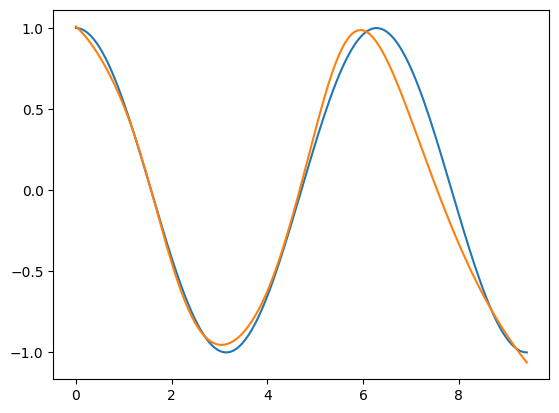

In [29]:
plt.plot(X, y)
plt.plot(X, batched_predict(params, X))